# Chapter 07: Transfer Learning from Long Time Series

Forecasting short time series is notoriously difficult. With only a few weeks or months of data, traditional methods struggle to capture long-term patterns like yearly seasonality. Yet in many business contexts, we *know* such patterns exist — we just haven't observed them yet.

This chapter demonstrates how to use **transfer learning** to overcome this limitation. The key insight: if we have a long time series that shares seasonal patterns with our short target series, we can:

1. Fit a model to the long series to learn its seasonal structure
2. Transfer the learned posteriors as priors to the short series model

This approach was inspired by:
- [Modeling Short Time Series with Prior Knowledge](https://minimizeregret.com/short-time-series-prior-knowledge) by Tim Radtke
- [Modeling Short Time Series with Prior Knowledge in PyMC](https://juanitorduz.github.io/short_time_series_pymc/) by Juan Orduz

Vangja was partially inspired by these two blog posts and implements parametric transfer learning as a core feature.

## The Scenario

We have daily bike sales data from a Citi Bike station in NYC, but only **~3 months** of history (July–October 2013). We need to forecast sales for the next year, including through winter and back to summer. 

The challenge: with only summer/fall data, how can we capture the yearly seasonality pattern where demand drops significantly in winter?

**The solution**: New York City temperature has a strong yearly pattern that correlates with bike demand. Even though we can't use temperature directly as a predictor (we'd need future forecasts), we *can* learn the shape of yearly seasonality from historical temperature data and transfer it to our sales model.

## Differences from the Original Blog Posts

The original implementations use:
- A negative binomial likelihood with autoregressive (AR) components on the latent mean
- A damped dynamic model: $\mu_t = (1-\delta-\eta)\lambda_t + \delta\mu_{t-1} + \eta y_{t-1}$

Vangja uses a simpler Prophet-like approach:
- A piecewise `LinearTrend` component instead of AR dynamics
- Gaussian likelihood
- Transfer learning via the `tune_method="parametric"` parameter on `FourierSeasonality`

Despite these differences, the core insight — transferring learned seasonality via Bayesian priors — works remarkably well.

## Setup and Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vangja import LinearTrend, FourierSeasonality
from vangja.datasets import load_citi_bike_sales, load_nyc_temperature
from vangja.utils import metrics

print("Imports successful!")

Imports successful!


---

## Load and Explore the Data

We load two datasets:
1. **Temperature data**: ~5 years of daily max temperatures for NYC (our "long" series)
2. **Bike sales data**: ~16 months of daily bike rides from Citi Bike station 360 (we'll use only ~3 months for training)

In [3]:
# Load the datasets
temp_df = load_nyc_temperature()
sales_df = load_citi_bike_sales()

print("Temperature data:")
print(f"  Shape: {temp_df.shape}")
print(f"  Date range: {temp_df['ds'].min().date()} to {temp_df['ds'].max().date()}")
print(f"  Days: {(temp_df['ds'].max() - temp_df['ds'].min()).days}")

print("\nSales data:")
print(f"  Shape: {sales_df.shape}")
print(f"  Date range: {sales_df['ds'].min().date()} to {sales_df['ds'].max().date()}")
print(f"  Days: {(sales_df['ds'].max() - sales_df['ds'].min()).days}")

Temperature data:
  Shape: (45253, 2)
  Date range: 2012-10-01 to 2017-11-30
  Days: 1885

Sales data:
  Shape: (822, 2)
  Date range: 2013-07-01 to 2015-09-30
  Days: 821


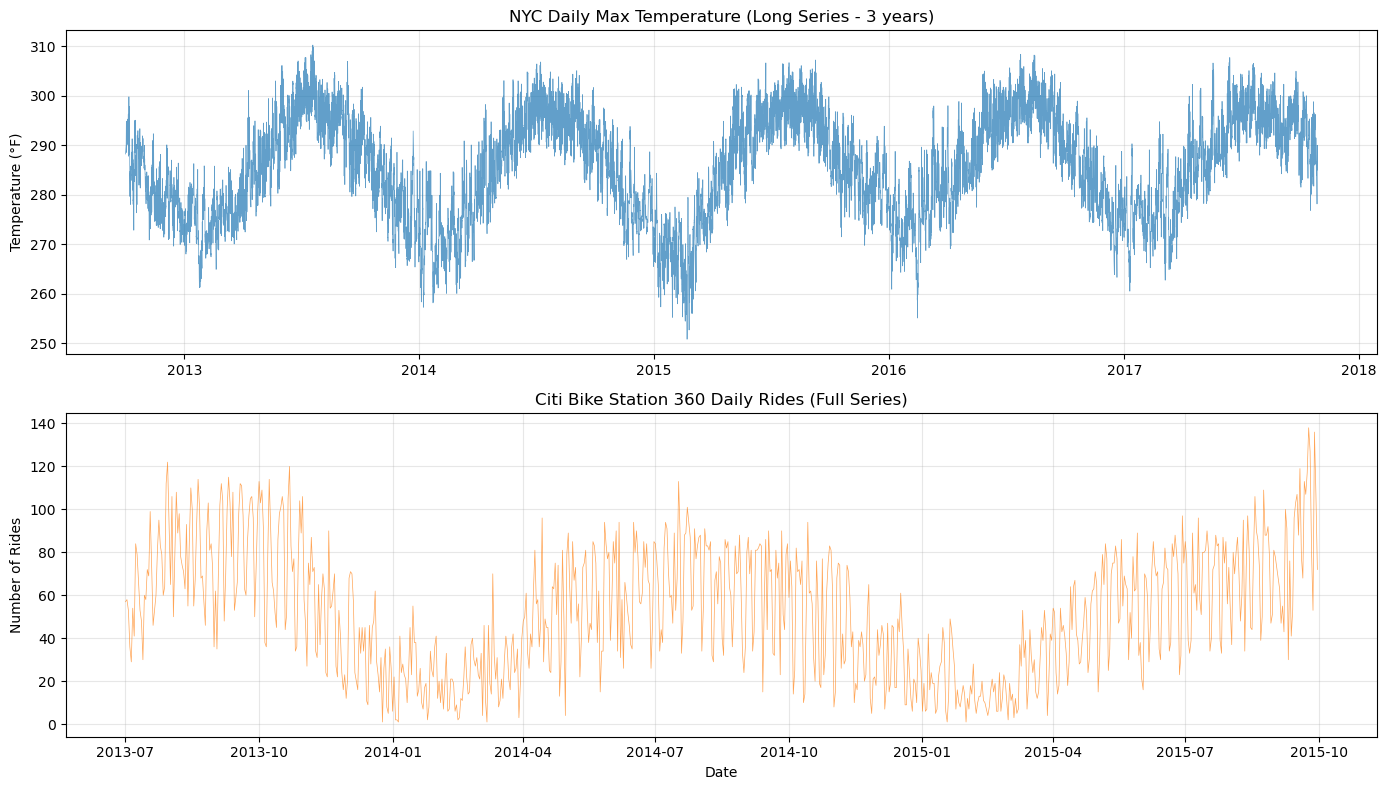

In [4]:
# Visualize both time series
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=False)

# Temperature
axes[0].plot(temp_df["ds"], temp_df["y"], "C0-", linewidth=0.5, alpha=0.7)
axes[0].set_title("NYC Daily Max Temperature (Long Series - 3 years)")
axes[0].set_ylabel("Temperature (°F)")
axes[0].grid(True, alpha=0.3)

# Sales
axes[1].plot(sales_df["ds"], sales_df["y"], "C1-", linewidth=0.5, alpha=0.7)
axes[1].set_title("Citi Bike Station 360 Daily Rides (Full Series)")
axes[1].set_ylabel("Number of Rides")
axes[1].set_xlabel("Date")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Create the Short Training Set

Following the original blog post, we use only the first ~3 months of sales data for training (up to October 15, 2013). The rest is held out as our test set.

In [5]:
# Define the train/test split date
train_test_date = pd.to_datetime("2013-10-15")

# Split the sales data
sales_train = sales_df[sales_df["ds"] < train_test_date].copy()
sales_test = sales_df[sales_df["ds"] >= train_test_date].copy()

print(f"Training period: {sales_train['ds'].min().date()} to {sales_train['ds'].max().date()}")
print(f"Training samples: {len(sales_train)} days")
print(f"\nTest period: {sales_test['ds'].min().date()} to {sales_test['ds'].max().date()}")
print(f"Test samples: {len(sales_test)} days")

Training period: 2013-07-01 to 2013-10-14
Training samples: 106 days

Test period: 2013-10-15 to 2015-09-30
Test samples: 716 days


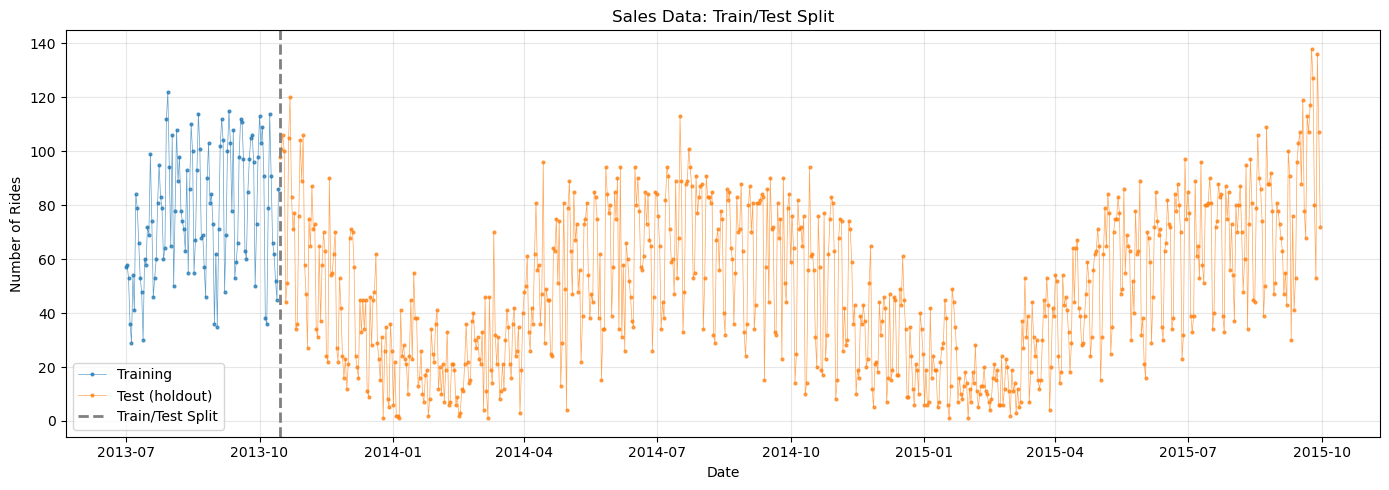


The challenge: We need to forecast through winter with only summer/fall data!


In [6]:
# Visualize the train/test split
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(sales_train["ds"], sales_train["y"], "C0o-", markersize=2, linewidth=0.5, alpha=0.7, label="Training")
ax.plot(sales_test["ds"], sales_test["y"], "C1o-", markersize=2, linewidth=0.5, alpha=0.7, label="Test (holdout)")
ax.axvline(train_test_date, color="gray", linestyle="--", linewidth=2, label="Train/Test Split")
ax.set_title("Sales Data: Train/Test Split")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nThe challenge: We need to forecast through winter with only summer/fall data!")

---

## Baseline: Prophet-like Model Without Transfer Learning

First, let's see what happens when we fit a standard Prophet-like model to the short training data — with yearly seasonality but no prior knowledge about its shape.

This is what most practitioners would try first, and it's exactly what fails in this scenario.

In [7]:
# Baseline model: Prophet-like with uninformed yearly seasonality
baseline_model = (
    LinearTrend()
    + FourierSeasonality(period=365.25, series_order=10)  # Yearly
    + FourierSeasonality(period=7, series_order=3)  # Weekly
)

print("Fitting baseline model (no transfer learning)...")
baseline_model.fit(sales_train, method="mapx")

# Predict over the full date range (train + test)
future_dates = pd.DataFrame({
    "ds": pd.date_range(sales_train["ds"].min(), sales_test["ds"].max(), freq="D")
})
baseline_pred = baseline_model.predict(
    horizon=len(sales_test), 
    freq="D"
)
print("Done!")

Fitting baseline model (no transfer learning)...


Output()

Done!


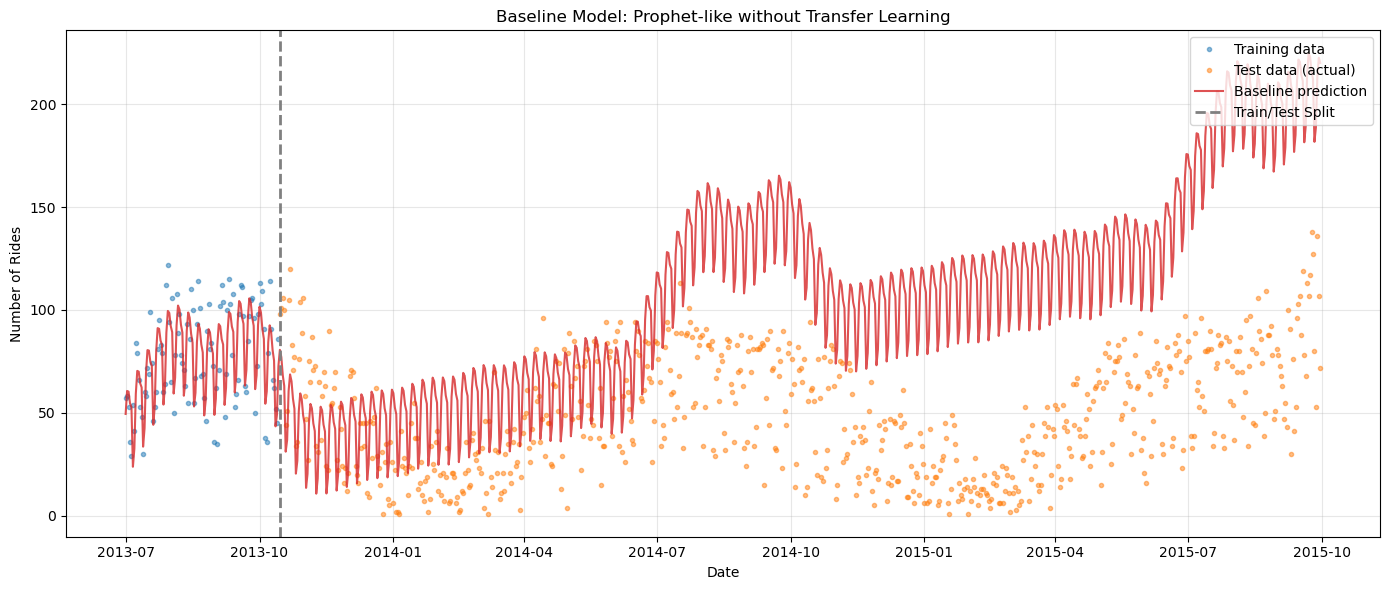


Observation: The baseline model fails to capture winter seasonality!
It extrapolates summer patterns into winter, vastly over-predicting demand.


In [8]:
# Plot baseline predictions vs actual data
fig, ax = plt.subplots(figsize=(14, 6))

# Training data
ax.plot(sales_train["ds"], sales_train["y"], "C0o", markersize=3, alpha=0.5, label="Training data")

# Test data (ground truth)
ax.plot(sales_test["ds"], sales_test["y"], "C1o", markersize=3, alpha=0.5, label="Test data (actual)")

# Baseline prediction
ax.plot(baseline_pred["ds"], baseline_pred["yhat_0"], "C3-", linewidth=1.5, alpha=0.8, label="Baseline prediction")

ax.axvline(train_test_date, color="gray", linestyle="--", linewidth=2, label="Train/Test Split")
ax.set_title("Baseline Model: Prophet-like without Transfer Learning")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservation: The baseline model fails to capture winter seasonality!")
print("It extrapolates summer patterns into winter, vastly over-predicting demand.")

---

## Step 1: Learn Seasonality from Temperature Data

Now we fit a model to the long temperature time series. The goal is to learn the shape of yearly seasonality — specifically, the posterior distribution of the Fourier coefficients.

Since temperature is much simpler than sales (just yearly seasonality, no weekly pattern, minimal trend), we use a simple model.

In [47]:
# Temperature model: Simple trend + yearly seasonality
# We use a very simple linear trend since temperature doesn't have growth
temp_model = (
    LinearTrend(
        n_changepoints=0, # No changepoints - we want a simple linear trend
        slope_mean=0,
        slope_sd=0.01,  # Very small - we don't expect a trend
        intercept_mean=0,
        intercept_sd=10,
    )
    + FourierSeasonality(period=365.25, series_order=6, beta_sd=1.0)
)

print("Fitting temperature model to learn yearly seasonality...")
temp_model.fit(temp_df, method="fullrank_advi", n=50000, samples=50000)

# Get predictions to visualize the fit
temp_pred = temp_model.predict(horizon=0, freq="D")
print("Done!")

Fitting temperature model to learn yearly seasonality...


Output()

Finished [100%]: Average Loss = -1.1783e+05


Done!


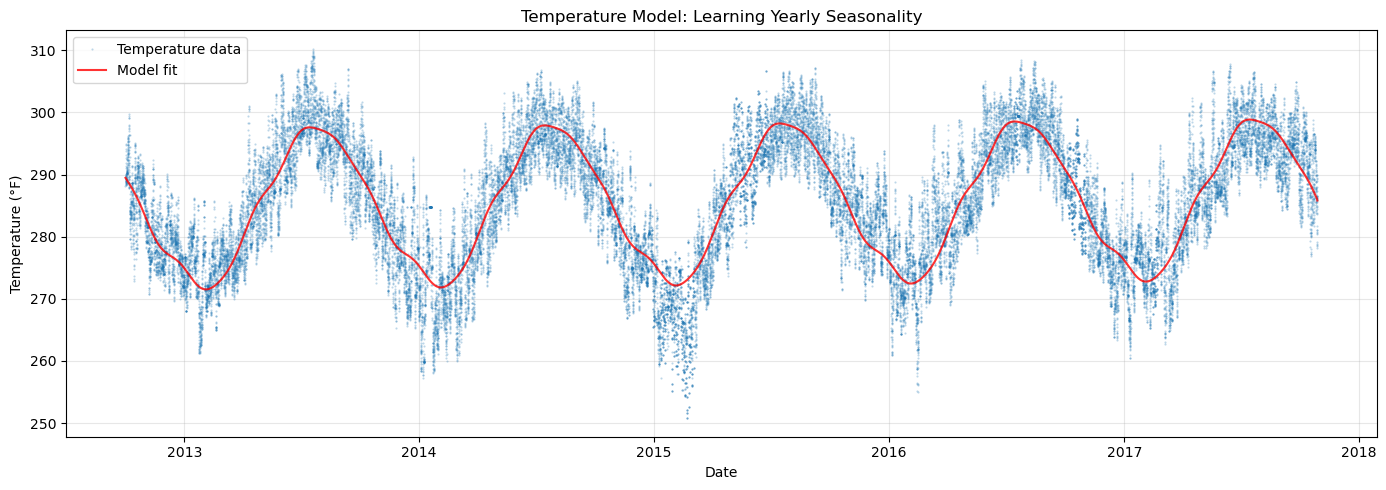

In [48]:
# Visualize temperature model fit
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(temp_df["ds"], temp_df["y"], "C0.", markersize=1, alpha=0.3, label="Temperature data")
ax.plot(temp_pred["ds"], temp_pred["yhat_0"], "r-", linewidth=1.5, alpha=0.8, label="Model fit")

ax.set_title("Temperature Model: Learning Yearly Seasonality")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°F)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

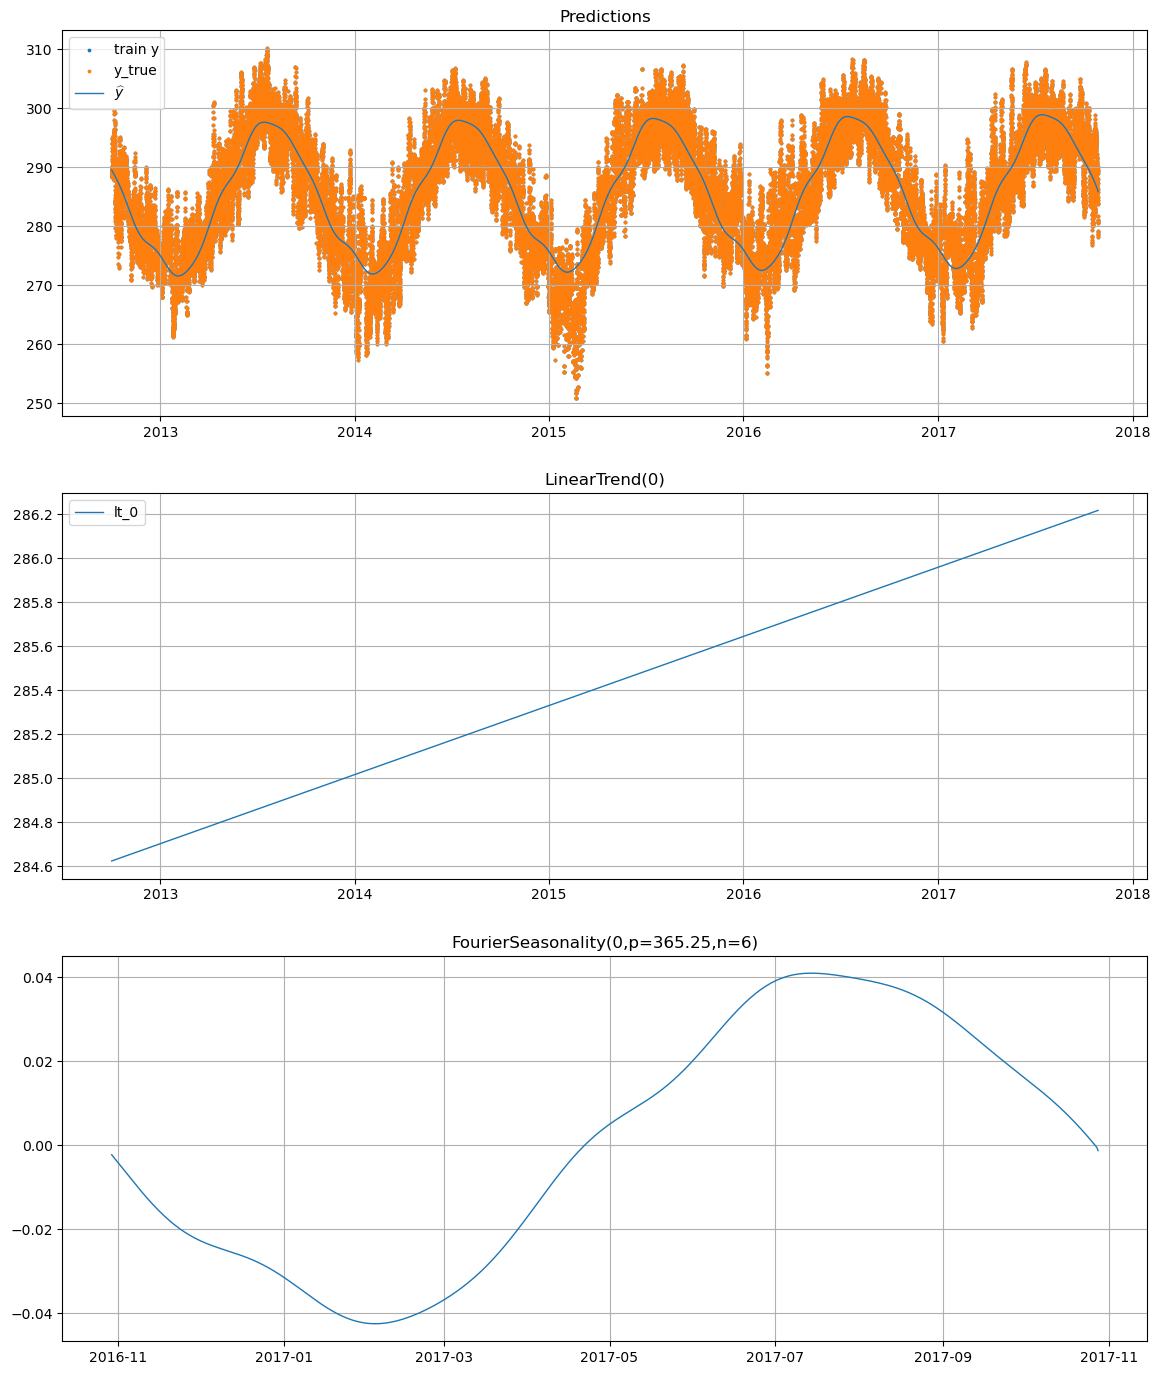

In [49]:
# Plot the component decomposition for the temperature model
temp_model.plot(temp_pred, y_true=temp_df)

### The Learned Fourier Coefficients

The temperature model has learned 12 Fourier coefficients (6 sine + 6 cosine terms) that describe the yearly seasonal pattern. These coefficients, stored in `idata_`, will be transferred as priors to the sales model.

Using the `tune_method="parametric"` option, vangja automatically extracts the posterior mean and standard deviation of these coefficients and uses them as the prior for the new model.

In [50]:
# Inspect the learned Fourier coefficients from the temperature model
# These are stored in the trace attribute after fitting
beta_key = "fs_0 - beta(p=365.25,n=6)"
beta_posterior = temp_model.trace["posterior"][beta_key]

# Calculate mean and std (what parametric tuning will use)
beta_mean = beta_posterior.mean(dim=["chain", "draw"]).values
beta_std = beta_posterior.std(dim=["chain", "draw"]).values

print("Learned Fourier coefficients from temperature model:")
print("-" * 50)
for i in range(len(beta_mean)):
    term_type = "sin" if i % 2 == 0 else "cos"
    order = (i // 2) + 1
    print(f"  {term_type}(order={order}): mean = {beta_mean[i]:7.3f}, std = {beta_std[i]:.4f}")
    
print("\nThese posteriors will become the priors for the sales model!")

Learned Fourier coefficients from temperature model:
--------------------------------------------------
  sin(order=1): mean =  -0.016, std = 0.0003
  cos(order=1): mean =  -0.037, std = 0.0006
  sin(order=2): mean =  -0.001, std = 0.0006
  cos(order=2): mean =   0.001, std = 0.0014
  sin(order=3): mean =  -0.001, std = 0.0018
  cos(order=3): mean =   0.001, std = 0.0013
  sin(order=4): mean =   0.001, std = 0.0012
  cos(order=4): mean =   0.002, std = 0.0022
  sin(order=5): mean =  -0.000, std = 0.0012
  cos(order=5): mean =  -0.000, std = 0.0021
  sin(order=6): mean =  -0.001, std = 0.0027
  cos(order=6): mean =   0.001, std = 0.0024

These posteriors will become the priors for the sales model!


However, as in any transfer learning scenario, we need to be careful to extract the scaling parameters for the timestamp column in `temp_model.data`. Let's take a look at them.

In [51]:
temp_model.t_scale_params

{'ds_min': Timestamp('2012-10-01 13:00:00'),
 'ds_max': Timestamp('2017-10-28 00:00:00')}

---

## Step 2: Transfer Learning to the Sales Model

Now we create a new model for sales that:
1. Has its own trend and weekly seasonality (learned from sales data)
2. **Transfers** the yearly seasonality from the temperature model via `tune_method="parametric"`

The `tune_method="parametric"` setting tells the `FourierSeasonality` component to:
- Extract the posterior mean and std of the Fourier coefficients from `idata`
- Use these as the prior mean and std for the new model's coefficients

This gives the sales model a strong, informed prior about what yearly seasonality looks like — even though it has never seen a full year of sales data.

In [90]:
temp_model.y_scale_params

{'scaler': 'maxabs', 'y_min': 0, 'y_max': np.float64(310.24)}

In [138]:
FourierSeasonality._get_beta_params_from_idata(transfer_model.left.right, temp_model.trace)

(array([-1.64626027e-02, -3.66212041e-02, -1.07584294e-03,  1.25257574e-03,
        -1.12693554e-03,  1.06832323e-03,  6.67194052e-04,  2.00398585e-03,
        -7.74504486e-05, -1.32187335e-04, -9.79014836e-04,  7.70155045e-04]),
 array([0.00030643, 0.00062484, 0.00064606, 0.00135104, 0.00176701,
        0.00126399, 0.00122859, 0.00221583, 0.00122165, 0.00205541,
        0.00270409, 0.00243785]))

In [137]:
str(transfer_model.left.right)

'FS(p=365.25,n=6,tm=parametric)'

In [161]:
# Transfer learning model: Use learned yearly seasonality
transfer_model = (
    LinearTrend()
    + FourierSeasonality(
        period=365.25,
        series_order=6,
        tune_method="parametric",  # KEY: Transfer from temperature model
        loss_factor_for_tune=1,  # Strongly encourage matching the temperature model's seasonality
        # override_beta_sd_for_tune=0.001
    )
    + FourierSeasonality(period=7, series_order=3)  # Weekly (learned from sales)
)

print("Fitting transfer learning model...")
print("  - Linear trend: learned from sales data")
print("  - Weekly seasonality: learned from sales data")
print("  - Yearly seasonality: TRANSFERRED from temperature model")

# Pass the temperature model's trace and scaling parameters to transfer the learned seasonality
transfer_model.fit(
    sales_train.iloc[2:],
    method="mapx",
    idata=temp_model.trace,
    t_scale_params=temp_model.t_scale_params,
)

# Predict over the full date range
transfer_pred = transfer_model.predict(horizon=len(sales_test), freq="D")

# Keep only the predictions for the train + test period (since predict returns the full range)
transfer_pred = transfer_pred[
    (transfer_pred["ds"] >= sales_train["ds"].min())
    & (transfer_pred["ds"] <= sales_test["ds"].max())
]
print("Done!")

Fitting transfer learning model...
  - Linear trend: learned from sales data
  - Weekly seasonality: learned from sales data
  - Yearly seasonality: TRANSFERRED from temperature model


Output()

Done!


In [163]:
transfer_pred

,ds,t,lt_0_0,fs_0_0,fs_1_0,yhat_0
273,2013-07-01 13:00:00,0.147372,170.788782,0.036729,0.050078,195.146909
274,2013-07-02 13:00:00,0.147912,170.808319,0.036876,0.140943,220.704292
275,2013-07-03 13:00:00,0.148451,170.827856,0.037014,0.112780,212.860207
276,2013-07-04 13:00:00,0.148991,170.847393,0.037145,0.055450,196.829657
277,2013-07-05 13:00:00,0.149531,170.866929,0.037271,0.028318,189.271355
...,...,...,...,...,...,...
1089,2015-09-25 13:00:00,0.587867,185.053304,0.019683,0.028318,198.522615
1090,2015-09-26 13:00:00,0.588407,185.070543,0.019323,-0.226083,127.053846
1091,2015-09-27 13:00:00,0.588947,185.087782,0.018961,-0.161487,145.094957
1092,2015-09-28 13:00:00,0.589487,185.105022,0.018595,0.050078,204.374675


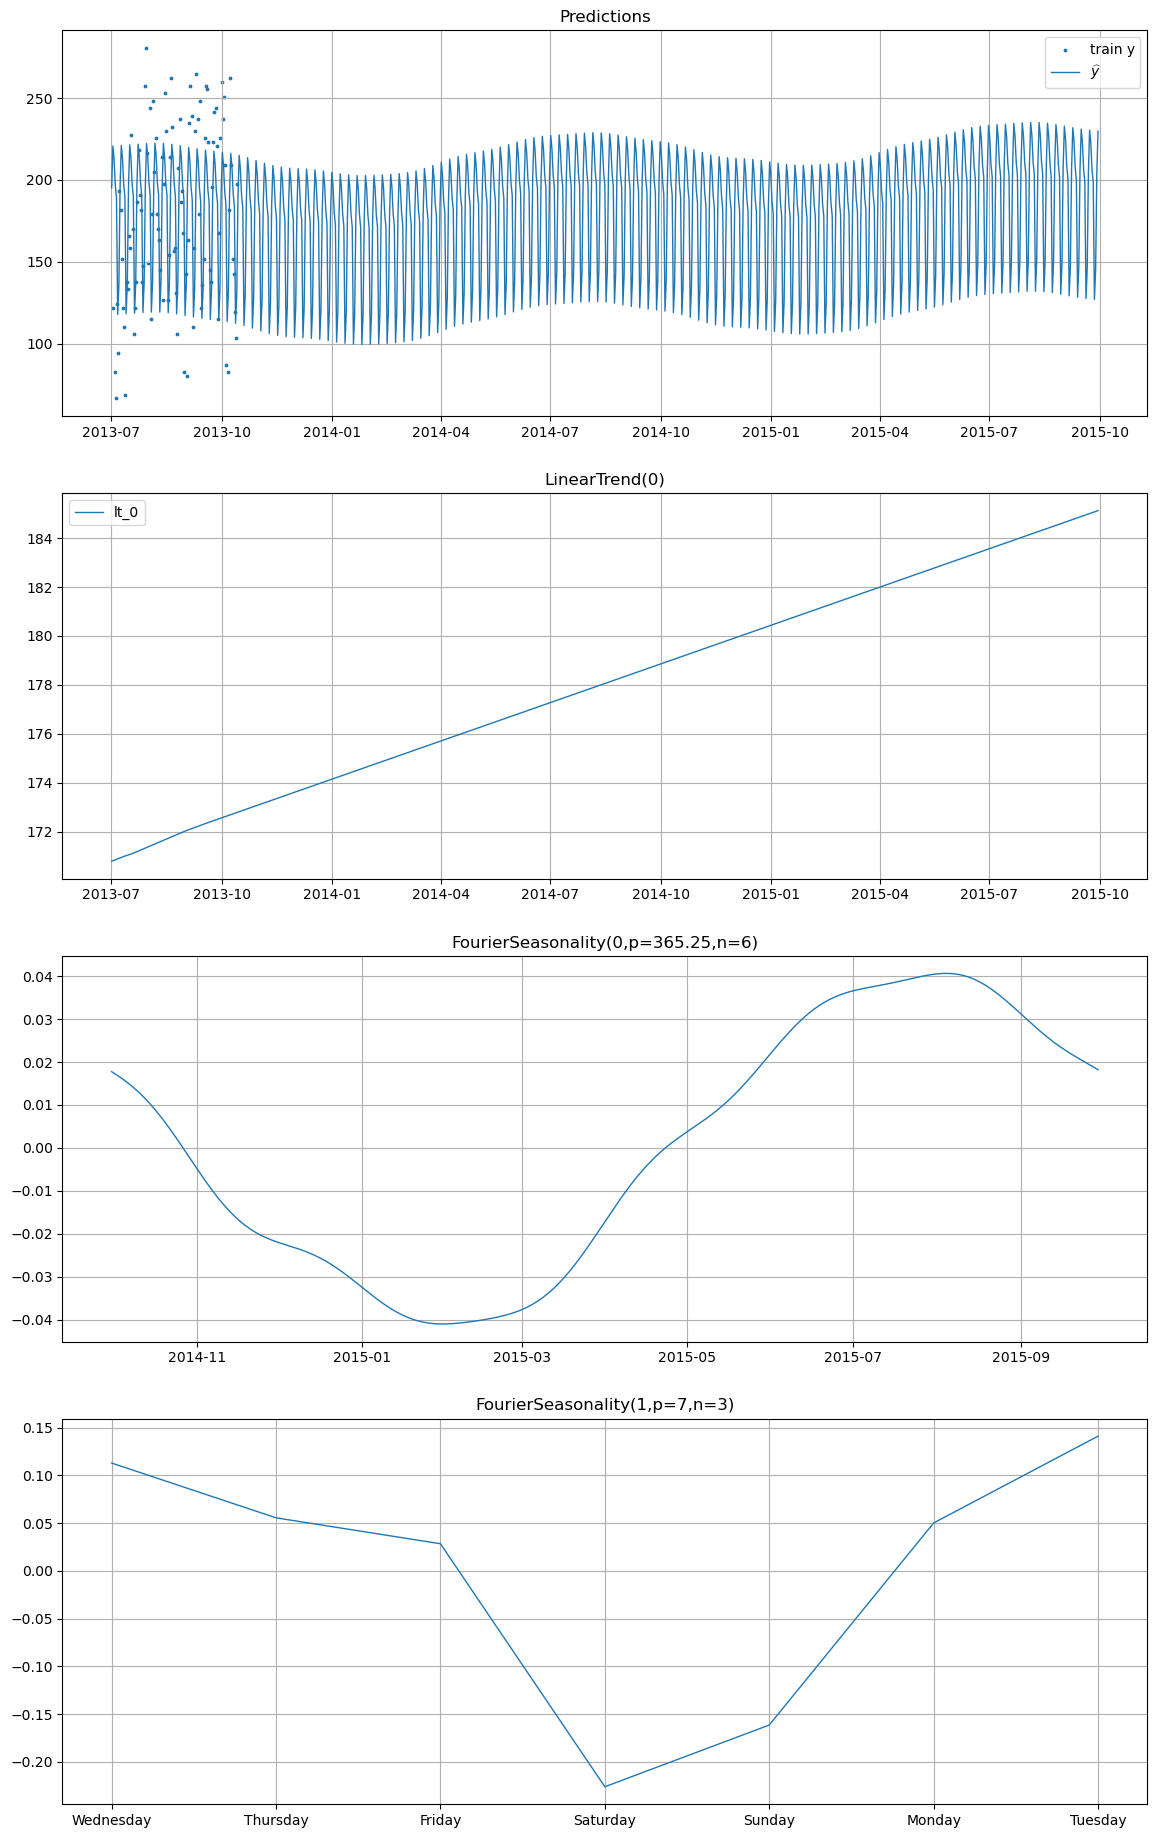

In [162]:
transfer_model.plot(transfer_pred)

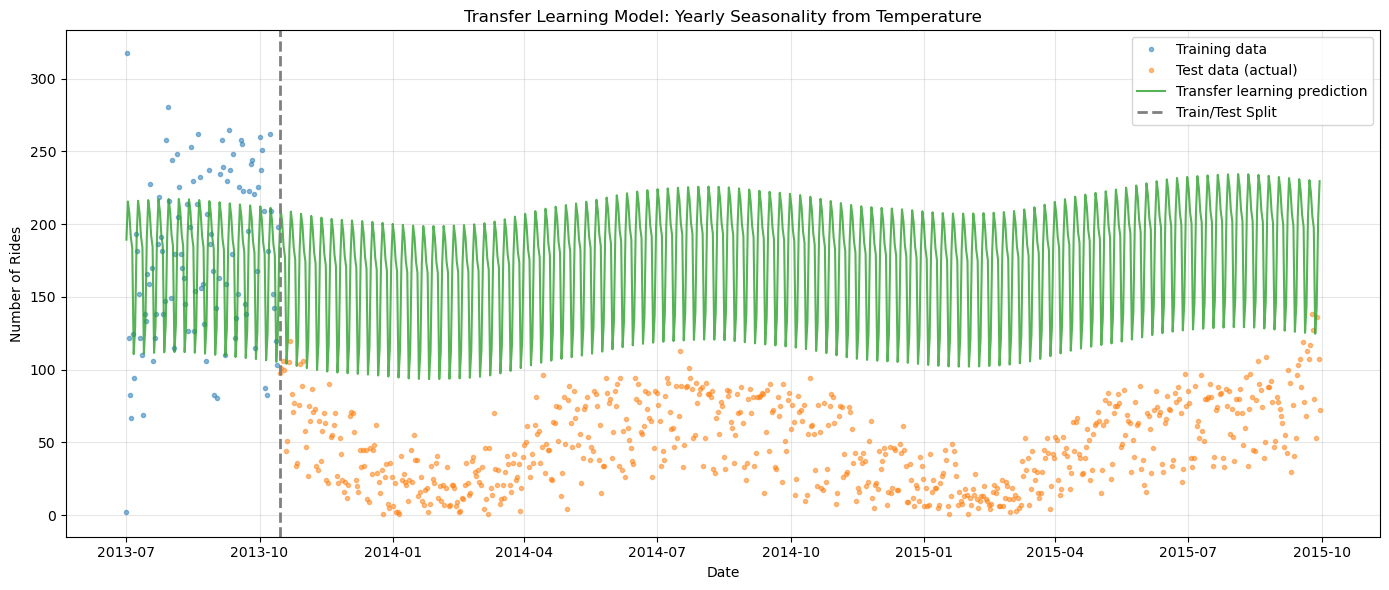


Observation: The transfer learning model captures the winter drop!
It correctly predicts lower demand in winter and recovery in spring/summer.


In [160]:
# Plot transfer learning predictions vs actual data
fig, ax = plt.subplots(figsize=(14, 6))

# Training data
ax.plot(sales_train["ds"], sales_train["y"], "C0o", markersize=3, alpha=0.5, label="Training data")

# Test data (ground truth)
ax.plot(sales_test["ds"], sales_test["y"], "C1o", markersize=3, alpha=0.5, label="Test data (actual)")

# Transfer learning prediction
ax.plot(transfer_pred["ds"], transfer_pred["yhat_0"], "C2-", linewidth=1.5, alpha=0.8, label="Transfer learning prediction")

ax.axvline(train_test_date, color="gray", linestyle="--", linewidth=2, label="Train/Test Split")
ax.set_title("Transfer Learning Model: Yearly Seasonality from Temperature")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservation: The transfer learning model captures the winter drop!")
print("It correctly predicts lower demand in winter and recovery in spring/summer.")

In [ ]:
# Plot component decomposition for the transfer learning model
transfer_model.plot(transfer_pred, y_true=sales_df)

---

## Comparison: Baseline vs Transfer Learning

Let's compare both models side-by-side to see the dramatic improvement from transfer learning.

In [ ]:
# Side-by-side comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

for ax, (model_name, pred, color) in zip(axes, [
    ("Baseline (no transfer)", baseline_pred, "C3"),
    ("Transfer Learning", transfer_pred, "C2"),
]):
    # Training data
    ax.plot(sales_train["ds"], sales_train["y"], "C0o", markersize=3, alpha=0.5, label="Training data")
    
    # Test data (ground truth)
    ax.plot(sales_test["ds"], sales_test["y"], "C1o", markersize=3, alpha=0.5, label="Test data (actual)")
    
    # Model prediction
    ax.plot(pred["ds"], pred["yhat_0"], f"{color}-", linewidth=1.5, alpha=0.8, label=f"{model_name} prediction")
    
    ax.axvline(train_test_date, color="gray", linestyle="--", linewidth=2)
    ax.set_title(f"{model_name}")
    ax.set_ylabel("Number of Rides")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

In [ ]:
# Overlay comparison
fig, ax = plt.subplots(figsize=(14, 6))

# Training data
ax.plot(sales_train["ds"], sales_train["y"], "C0o", markersize=3, alpha=0.4, label="Training data")

# Test data (ground truth)
ax.plot(sales_test["ds"], sales_test["y"], "C1o", markersize=3, alpha=0.4, label="Test data (actual)")

# Both predictions
ax.plot(baseline_pred["ds"], baseline_pred["yhat_0"], "C3-", linewidth=1.5, alpha=0.8, label="Baseline prediction")
ax.plot(transfer_pred["ds"], transfer_pred["yhat_0"], "C2-", linewidth=1.5, alpha=0.8, label="Transfer learning prediction")

ax.axvline(train_test_date, color="gray", linestyle="--", linewidth=2, label="Train/Test Split")
ax.set_title("Comparison: Baseline vs Transfer Learning")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Quantitative Comparison

Let's compute error metrics on the test set to quantify the improvement.

In [ ]:
# Compute metrics on test set
def compute_test_metrics(pred_df, test_df):
    """Compute RMSE, MAE, MAPE on the test set."""
    # Merge predictions with test data on date
    merged = test_df.merge(
        pred_df[["ds", "yhat_0"]], 
        on="ds", 
        how="inner"
    )
    
    y_true = merged["y"].values
    y_pred = merged["yhat_0"].values
    
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {"RMSE": rmse, "MAE": mae, "MAPE (%)": mape}

# Calculate metrics
baseline_metrics = compute_test_metrics(baseline_pred, sales_test)
transfer_metrics = compute_test_metrics(transfer_pred, sales_test)

# Also compute a simple mean baseline
mean_pred_value = sales_train["y"].mean()
mean_metrics = {
    "RMSE": np.sqrt(np.mean((sales_test["y"].values - mean_pred_value) ** 2)),
    "MAE": np.mean(np.abs(sales_test["y"].values - mean_pred_value)),
    "MAPE (%)": np.mean(np.abs((sales_test["y"].values - mean_pred_value) / sales_test["y"].values)) * 100,
}

# Display comparison table
comparison_df = pd.DataFrame({
    "Mean Baseline": mean_metrics,
    "Prophet-like (no transfer)": baseline_metrics,
    "Transfer Learning": transfer_metrics,
}).T

print("Test Set Metrics Comparison")
print("=" * 60)
display(comparison_df.round(2))

In [ ]:
# Calculate improvement percentages
rmse_improvement = (1 - transfer_metrics["RMSE"] / baseline_metrics["RMSE"]) * 100
mae_improvement = (1 - transfer_metrics["MAE"] / baseline_metrics["MAE"]) * 100

print(f"\nImprovement from Transfer Learning:")
print(f"  RMSE reduction: {rmse_improvement:.1f}%")
print(f"  MAE reduction:  {mae_improvement:.1f}%")

---

## How It Works: The Parametric Transfer

The `tune_method="parametric"` option in vangja implements a simple but powerful form of Bayesian transfer learning:

### Step 1: Fit the Source Model
```python
temp_model.fit(temp_df, method="mapx")
```
The temperature model learns Fourier coefficients $\beta_1, \ldots, \beta_{12}$ from ~5 years of data. The posterior is stored in `temp_model.idata_`.

### Step 2: Extract Posterior Statistics
When fitting the sales model with `idata=temp_model.idata_`, vangja extracts:
- $\mu_i = \mathbb{E}[\beta_i | \text{data}]$ — posterior mean
- $\sigma_i = \text{Std}[\beta_i | \text{data}]$ — posterior standard deviation

### Step 3: Set Informed Priors
The sales model's Fourier coefficients receive Normal priors:

$$\beta^{\text{sales}}_i \sim \text{Normal}(\mu_i, \sigma_i)$$

This is much more informative than the default $\beta \sim \text{Normal}(0, 10)$. The sales model's optimization process now starts with a strong belief about the seasonal shape, learned from temperature.

### Why This Works

Temperature and bike sales share a causal driver: **weather/seasons**. When temperature drops in winter:
- Fewer people want to bike in the cold
- The yearly seasonal pattern in temperature *correlates* with bike demand

By learning the shape of yearly seasonality from temperature (where we have years of data), we can transfer this knowledge to sales (where we have only months).

---

## Limitations and Considerations

### What We Simplified

The original blog posts use a more sophisticated model:
- **Negative binomial likelihood** for count data (we use Gaussian)
- **Autoregressive dynamics**: $\mu_t = (1-\delta-\eta)\lambda_t + \delta\mu_{t-1} + \eta y_{t-1}$
- **Day-of-week effects** as explicit dummy variables

Vangja's approach is simpler:
- We use a Gaussian likelihood (adequate for this scale of data)
- Instead of AR dynamics, we use `LinearTrend` with changepoints
- Weekly seasonality is learned via `FourierSeasonality(period=7)`

Despite these simplifications, the core insight — transferring learned seasonality via Bayesian priors — works well.

### When Transfer Learning Helps

Transfer learning is most valuable when:
1. **Short target series**: Not enough data to learn long-term patterns
2. **Long source series**: Available related data with the pattern you need
3. **Shared patterns**: The source and target genuinely share the pattern to transfer

### Potential Pitfalls

1. **Over-confident priors**: If the temperature seasonality doesn't match sales at all, strong priors could hurt. Consider increasing `beta_sd` or using less restrictive priors.

2. **Scale mismatch**: Temperature is in °F, sales is in counts. Vangja handles this by scaling data internally, and the Fourier coefficients represent *shape*, not magnitude.

3. **Phase mismatch**: If the seasonal peaks don't align (e.g., sales peak occurs 2 weeks after temperature peak), you may need the `shift_for_tune` option.

---

## Summary

In this chapter, we demonstrated how to use **transfer learning** to forecast short time series with vangja:

1. **The Problem**: With only ~3 months of bike sales data, standard methods fail to capture yearly seasonality, leading to wildly optimistic winter forecasts.

2. **The Solution**: Learn yearly seasonality from a related long time series (NYC temperature, ~5 years) and transfer it as informed priors to the sales model.

3. **The Implementation**:
   - Fit a model to temperature data to learn Fourier coefficients
   - Create a sales model with `tune_method="parametric"` on yearly seasonality
   - Pass `idata=temp_model.idata_` to transfer the learned posteriors as priors

4. **The Result**: The transfer learning model captures the winter demand drop and achieves significantly lower forecast errors than the baseline.

### Key Takeaways

- **Transfer learning in vangja** uses `tune_method="parametric"` to pass posterior mean/std as new priors
- **Find a proxy**: When your target series is short, look for a longer related series that shares patterns
- **Domain knowledge matters**: The insight that temperature correlates with bike demand made this transfer work
- **Simple can work**: Even with Vangja's simpler Prophet-like approach (vs. the original AR model), the core transfer learning insight delivers strong results

### Further Reading

- [Modeling Short Time Series with Prior Knowledge](https://minimizeregret.com/short-time-series-prior-knowledge) — the original blog post by Tim Radtke
- [Modeling Short Time Series with Prior Knowledge in PyMC](https://juanitorduz.github.io/short_time_series_pymc/) — Juan Orduz's PyMC implementation
- [Rob Hyndman: Fitting Models to Short Time Series](https://robjhyndman.com/hyndsight/short-time-series/) — context on the challenges of short series forecasting